In [535]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole

In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

from src.parameters import (ANIMALS, SAMPLING_FREQUENCY)

In [3]:
epoch_key = ('HPa', 6, 2)

In [7]:
from loren_frank_data_processing import make_neuron_dataframe
neuron_info = make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False).query('numspikes > 0')
neuron_info

animal  area       csi  day  \
animal day epoch tetrode_number neuron_number                               
HPa    6   2     1              1                HPa   CA1  0.004049    6   
                                2                HPa   CA1  0.117225    6   
                                3                HPa   CA1  0.042945    6   
                                4                HPa   CA1  0.104167    6   
                                5                HPa   CA1  0.091950    6   
                                6                HPa   CA1  0.093514    6   
                 4              1                HPa   CA1  0.206349    6   
                                2                HPa   CA1  0.088235    6   
                                3                HPa   CA1  0.023166    6   
                                4                HPa   CA1  0.151860    6   
                                5                HPa   CA1  0.154930    6   
                                6                HPa   CA1  0.047794    6   
                 5              1                HPa   CA1  0.267584    6   
                                2                HPa   CA1  0.097618    6   
                                4                HPa   CA1  0.195122    6   
                                5                HPa   CA1  0.069979    6   
                 8              1                HPa  iCA1  0.048257    6   
                 9              1                HPa  iCA1  0.087662    6   
                 10             1                HPa  iCA1  0.067797    6   
                 11             1                HPa  iCA1  0.139106    6   
                 12             1                HPa  iCA1  0.032258    6   
                 14             1                HPa  iCA1  0.087108    6   
                 17             1                HPa   PFC  0.205399    6   
                 18             1                HPa   PFC  0.006277    6   

                                               epoch   meanrate  \
animal day epoch tetrode_number neuron_number                     
HPa    6   2     1              1                  2   0.409959   
                                2                  2   0.346888   
                                3                  2   0.405809   
                                4                  2   0.159336   
                                5                  2   2.247303   
                                6                  2   0.550207   
                 4              1                  2   0.156846   
                                2                  2   0.112863   
                                3                  2   0.214938   
                                4                  2   1.092946   
                                5                  2   0.235685   
                                6                  2   0.451452   
                 5              1                  2   0.542739   
                                2                  2   2.473859   
                                4                  2   0.544398   
                                5                  2   2.004149   
                 8              1                  2   0.309544   
                 9              1                  2   0.511203   
                 10             1                  2   0.293776   
                 11             1                  2   1.169295   
                 12             1                  2   0.308714   
                 14             1                  2   0.238174   
                 17             1                  2  56.261411   
                 18             1                  2   1.321992   

                                                       neuron_id  \
animal day epoch tetrode_number neuron_number                      
HPa    6   2     1              1              HPa_06_02_001_001   
                                2              HPa_06_02_001_002   
                            

In [18]:
from loren_frank_data_processing import get_spike_indicator_dataframe, reshape_to_segments

neuron_key = ('HPa', 6, 2, 1, 1)
spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS).rename('is_spike')
print(spikes.shape)
spikes.head()

(1807541,)


time
01:08:42.992000    0
01:08:42.992667    0
01:08:42.993334    0
01:08:42.994001    0
01:08:42.994668    0
Freq: 667U, Name: is_spike, dtype: int64

In [11]:
from loren_frank_data_processing import get_interpolated_position_dataframe

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)
print(position_info.shape)
position_info.head()

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/EEG/HPaeeg06-2-20.mat
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/loren_frank_data_processing/position.py:193: RuntimeWarning: invalid value encountered in less
  at_target = distance_from_target < max_distance


(1807541, 10)


labeled_segments from_well to_well task is_correct  \
time                                                                  
01:08:42.992000               NaN       NaN     NaN  NaN        NaN   
01:08:42.992667               NaN       NaN     NaN  NaN        NaN   
01:08:42.993334               NaN       NaN     NaN  NaN        NaN   
01:08:42.994001               NaN       NaN     NaN  NaN        NaN   
01:08:42.994668               NaN       NaN     NaN  NaN        NaN   

                 linear_distance  x_position  y_position  head_direction  \
time                                                                       
01:08:42.992000              NaN         NaN         NaN             NaN   
01:08:42.992667              NaN         NaN         NaN             NaN   
01:08:42.993334              NaN         NaN         NaN             NaN   
01:08:42.994001              NaN         NaN         NaN             NaN   
01:08:42.994668              NaN         NaN         NaN             NaN   

                 speed  
time                    
01:08:42.992000    NaN  
01:08:42.992667    NaN  
01:08:42.993334    NaN  
01:08:42.994001    NaN  
01:08:42.994668    NaN

### 1D model of position

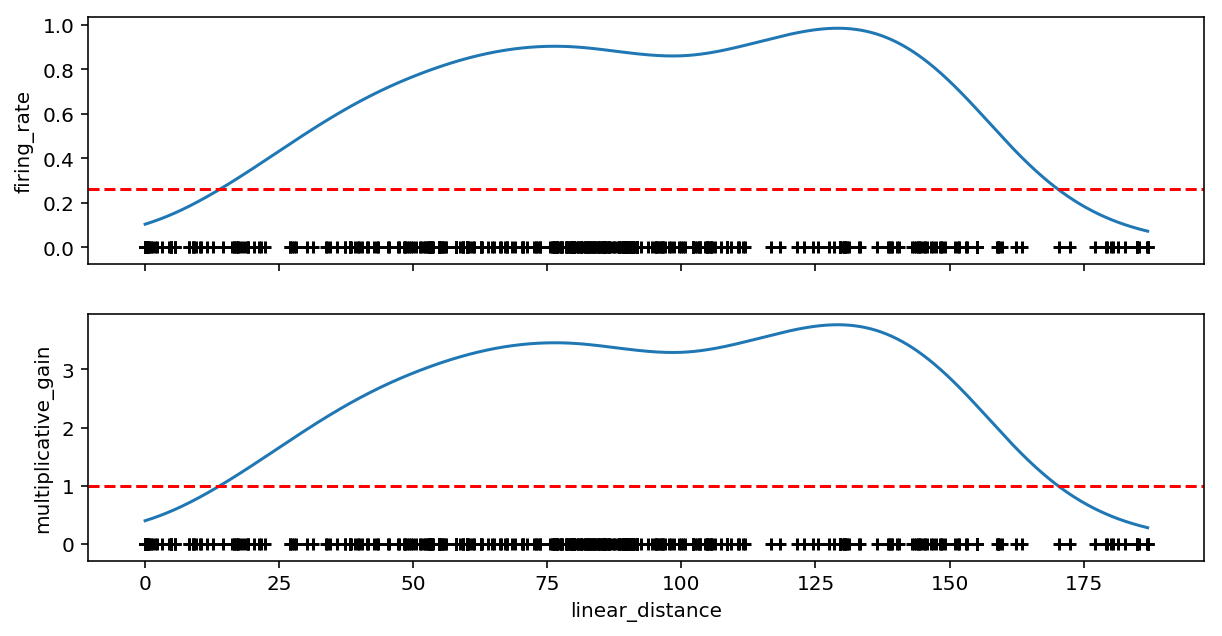

In [401]:
from patsy import build_design_matrices, dmatrices
from statsmodels.api import GLM, families

data = (position_info.join(spikes)
        .drop(['from_well', 'to_well', 'labeled_segments', 'is_correct', 'task'], axis=1)
        .dropna())

response, design_matrix = dmatrices('is_spike ~ 1 + cr(linear_distance, df=6, constraints="center")', data, return_type='dataframe')
model = GLM(response, design_matrix, family=families.Poisson())
fit = model.fit()
model_coefficients = fit.params

predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], dict(linear_distance=np.unique(data.linear_distance)))[0]

coords = {'linear_distance': np.unique(data.linear_distance)}

firing_rate = xr.DataArray(
    np.exp(np.dot(predict_design_matrix, model_coefficients)) *
    SAMPLING_FREQUENCY, dims=['linear_distance'],
    coords=coords, name='firing_rate')
multiplicative_gain = xr.DataArray(np.exp(
    np.dot(predict_design_matrix[:, 1:], model_coefficients[1:])),
    dims=['linear_distance'], coords=coords,
    name='multiplicative_gain')
baseline_firing_rate = xr.DataArray(np.exp(
    model_coefficients[0]) * SAMPLING_FREQUENCY,
    name='baseline_firing_rate')

f, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

firing_rate.plot(ax=axes[0])
s = data.linear_distance[data.is_spike > 0]
axes[0].scatter(s, np.zeros_like(s), marker='+', color='black')
axes[0].axhline(baseline_firing_rate, linestyle='--', color='red')
axes[0].set_xlabel('')

multiplicative_gain.plot(ax=axes[1])
axes[1].scatter(s, np.zeros_like(s), marker='+', color='black')
axes[1].axhline(1, linestyle='--', color='red')

## 1D model of speed

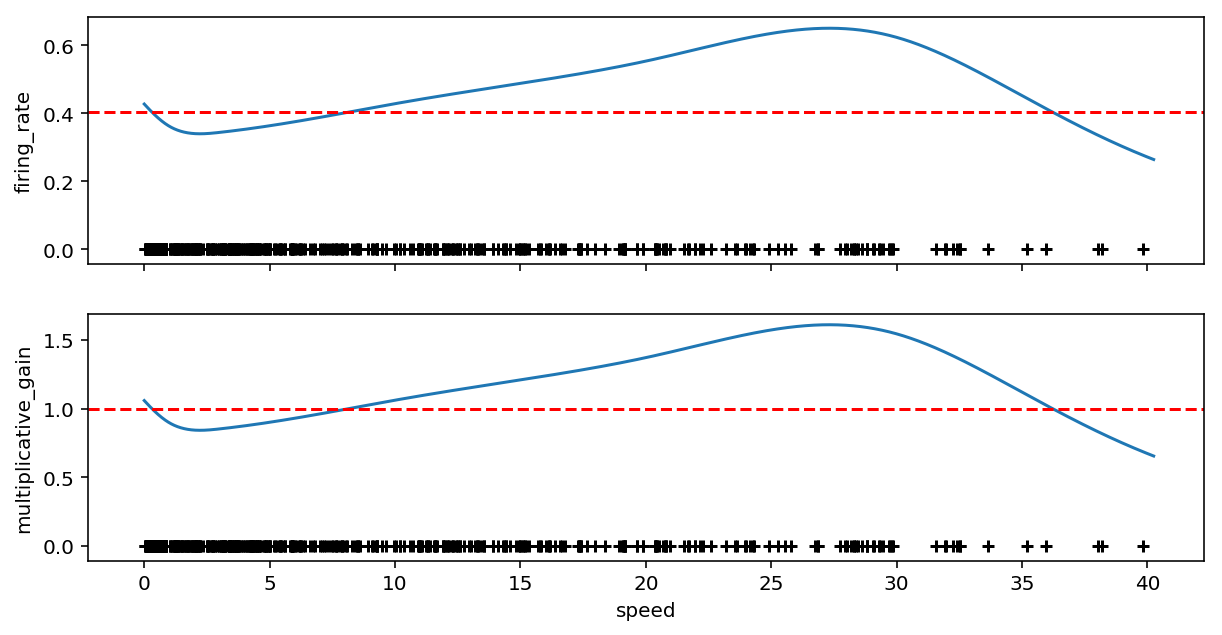

In [305]:
from patsy import build_design_matrices, dmatrices
from statsmodels.api import GLM, families

speed_knots = [1, 3, 10, 20, 30]

response, design_matrix = dmatrices('is_spike ~ 1 + cr(speed, knots=speed_knots, constraints="center")',
                                    data, return_type='dataframe')
model = GLM(response, design_matrix, family=families.Poisson())
fit = model.fit()
model_coefficients = fit.params

predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], dict(speed=np.unique(data.speed)))[0]

coords = {'speed': np.unique(data.speed)}

firing_rate = xr.DataArray(
    np.exp(np.dot(predict_design_matrix, model_coefficients)) *
    SAMPLING_FREQUENCY, dims=['speed'],
    coords=coords, name='firing_rate')
multiplicative_gain = xr.DataArray(np.exp(
    np.dot(predict_design_matrix[:, 1:], model_coefficients[1:])),
    dims=['speed'], coords=coords,
    name='multiplicative_gain')
baseline_firing_rate = xr.DataArray(np.exp(
    model_coefficients[0]) * SAMPLING_FREQUENCY,
    name='baseline_firing_rate')

f, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

firing_rate.plot(ax=axes[0])
s = data.speed[data.is_spike > 0]
axes[0].scatter(s, np.zeros_like(s), marker='+', color='black')
axes[0].axhline(baseline_firing_rate, linestyle='--', color='red')
axes[0].set_xlabel('')

multiplicative_gain.plot(ax=axes[1])
axes[1].scatter(s, np.zeros_like(s), marker='+', color='black')
axes[1].axhline(1, linestyle='--', color='red')

## 2D model of position

In [404]:
df = 5
formula = 'is_spike ~ 1 + te(cr(x_position, df=df), cr(y_position, df=df), constraints="center")'
penalty = 1E-4

response, design_matrix = dmatrices(formula, data, return_type='dataframe')
model = GLM(response, design_matrix, family=families.Poisson())
regularization_weights = np.ones((design_matrix.shape[1],)) * penalty
regularization_weights[model.exog_names.index('Intercept')] = 0.0
fit = model.fit_regularized(alpha=regularization_weights, L1_wt=0)
model_coefficients = fit.params

In [405]:
x = np.linspace(data.x_position.min(), data.x_position.max(), 100)
y = np.linspace(data.y_position.min(), data.y_position.max(), 100)
x, y = np.meshgrid(x, y)
predict_data = {'x_position': x.ravel(), 'y_position': y.ravel()}
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

firing_rate = np.exp(np.dot(predict_design_matrix, model_coefficients)) * SAMPLING_FREQUENCY

Text(0.5,0,'x_position')

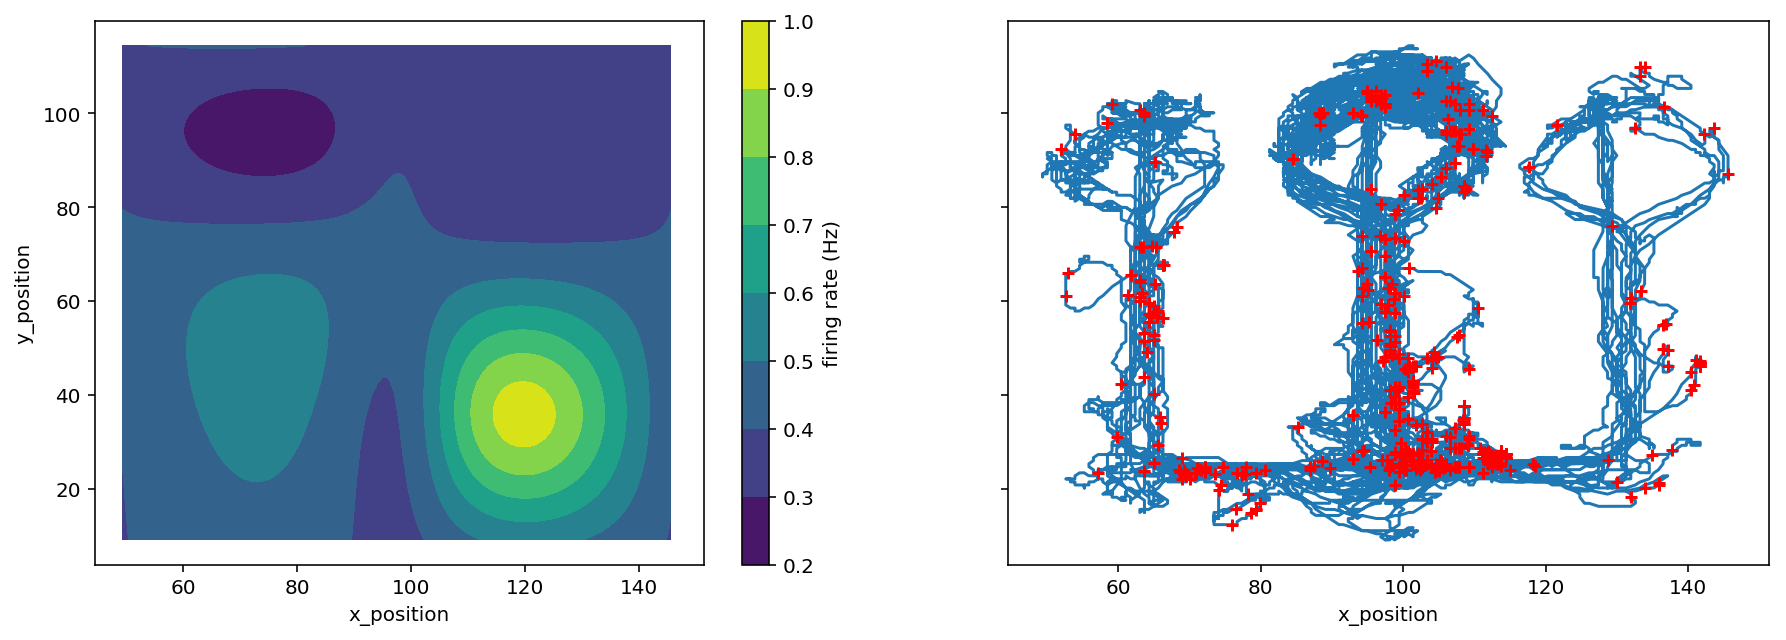

In [308]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
m = axes[0].contourf(x, y, firing_rate.reshape(x.shape));
plt.colorbar(m, ax=axes[0], label='firing rate (Hz)')
axes[0].scatter(data.x_position[s], data.y_position[s],
                marker='+', color='red', s=40, zorder=100, alpha=0.3)
axes[0].set_xlabel('x_position')
axes[0].set_ylabel('y_position')
axes[1].plot(data.x_position, data.y_position)
s = data.is_spike > 0
axes[1].scatter(data.x_position[s], data.y_position[s], marker='+', color='red', s=40, zorder=100)
axes[1].set_xlabel('x_position')

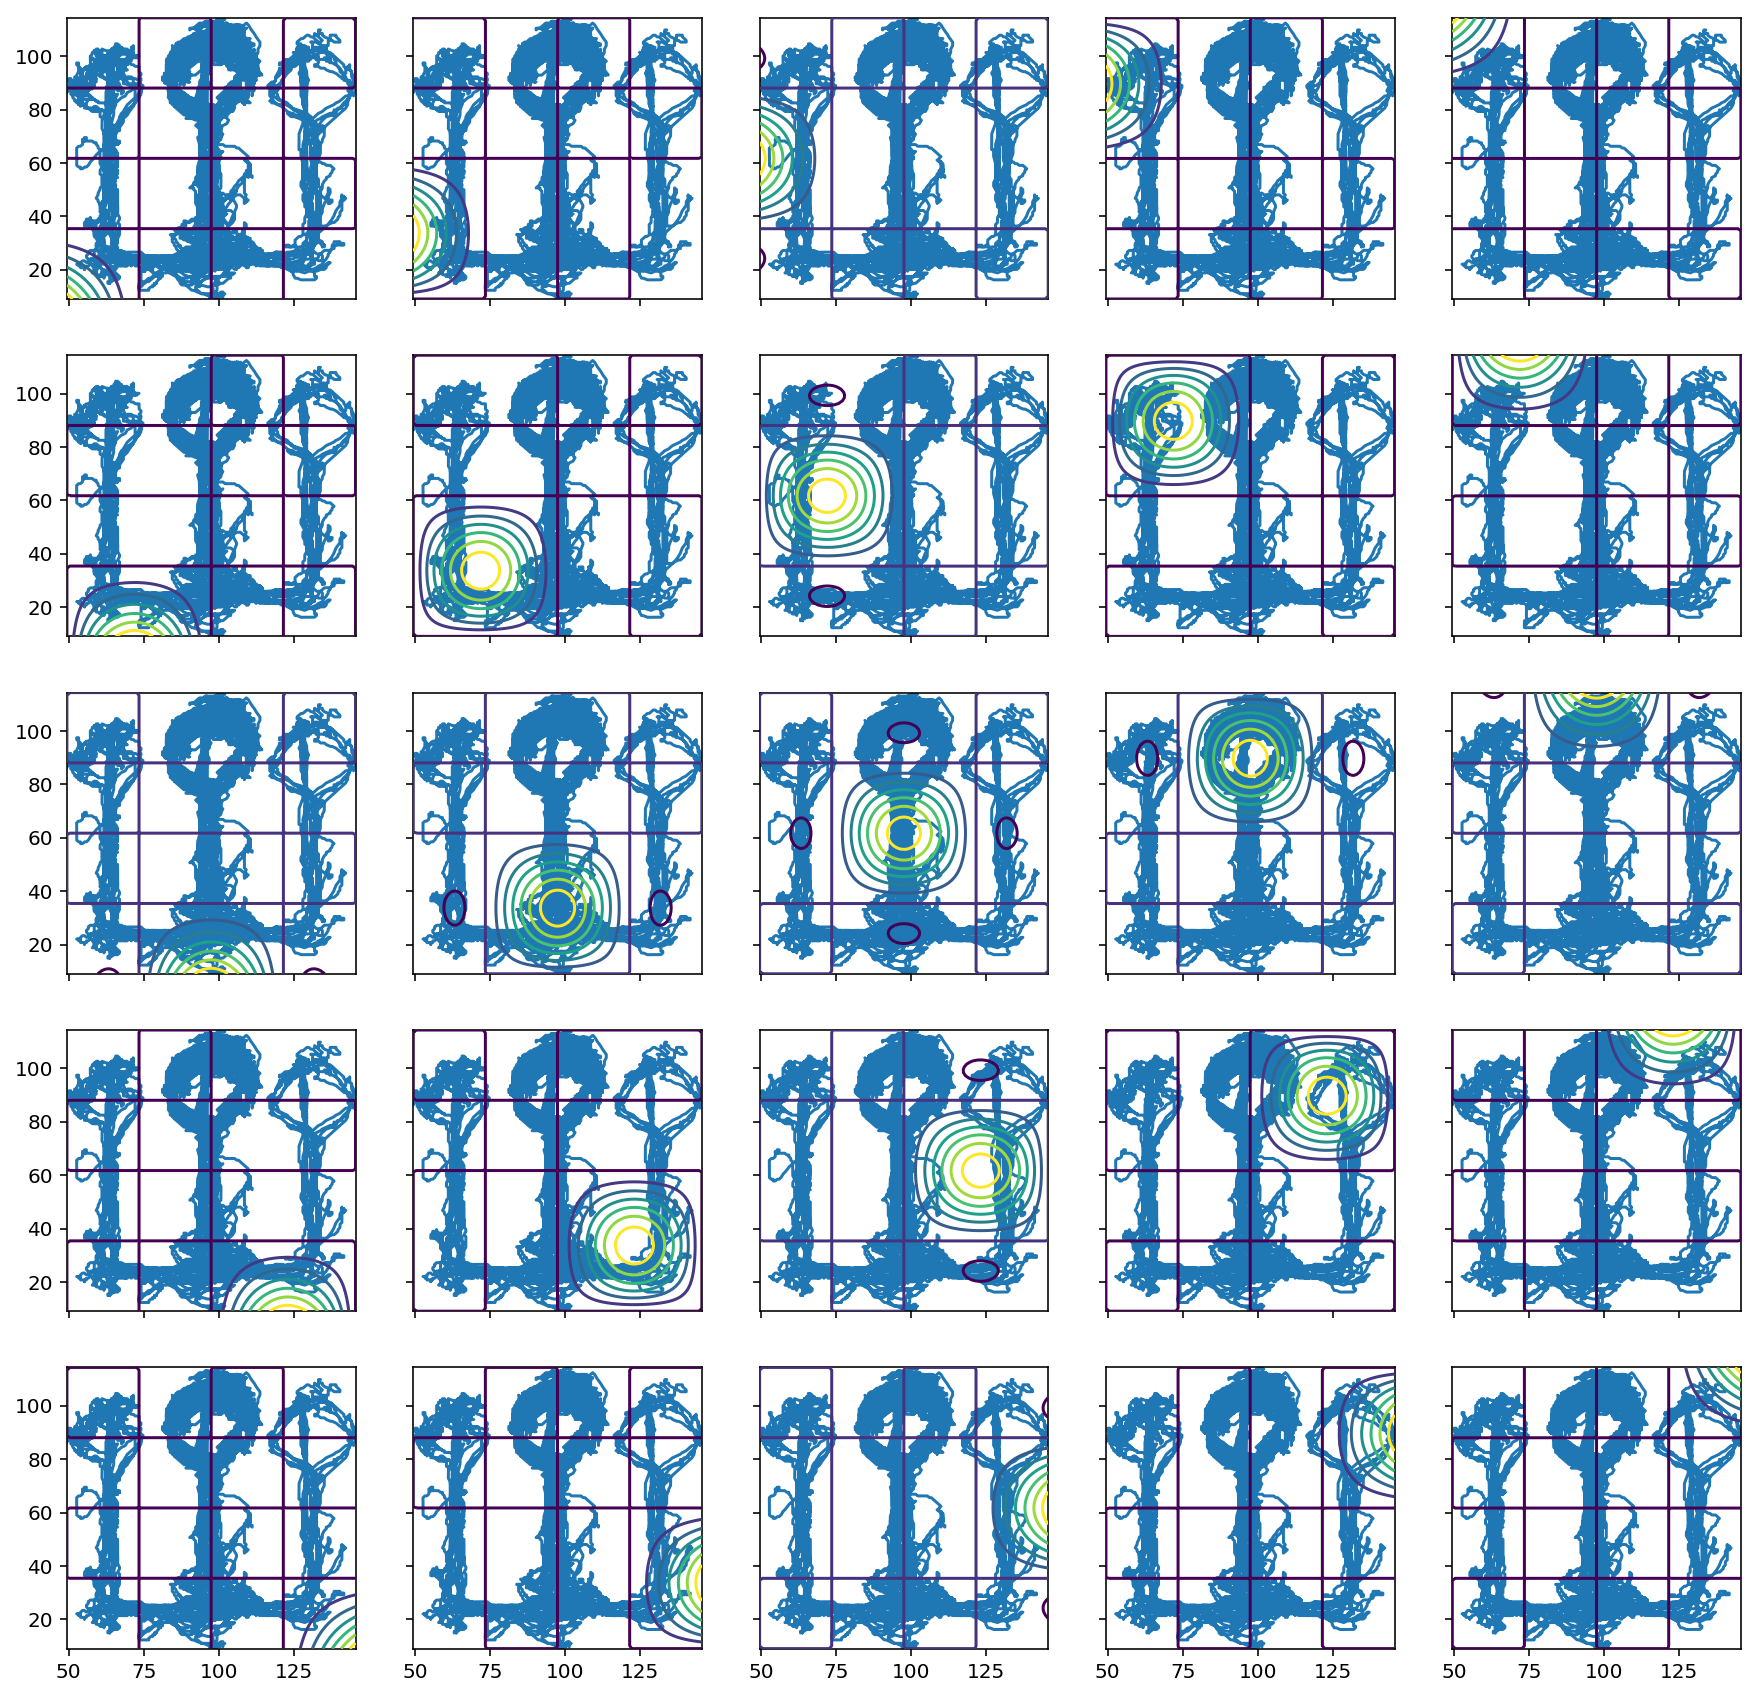

In [321]:
df = 5
d = dmatrix('te(cr(x_position, df=df), cr(y_position, df=df)) - 1', predict_data)
fig, axes = plt.subplots(df, df, figsize=(15, 15), sharex=True, sharey=True)
for ax, z in zip(axes.ravel(), d.T):
    ax.plot(data.x_position, data.y_position)
    ax.contour(x, y, z.reshape(x.shape), zorder=100)

In [406]:
from loren_frank_data_processing.core import get_data_structure
animal, day, epoch = epoch_key
task_file = get_data_structure(ANIMALS[animal], day, 'task', 'task')
linearcoord = task_file[epoch - 1]['linearcoord'][0, 0].squeeze()

coordinates = np.concatenate([arm[:, :, 0] for arm in linearcoord])
coordinates = np.unique(coordinates, axis=0)
def cluster(data, maxgap=5):
    '''Arrange data into groups where successive elements
       differ by no more than *maxgap*

        >>> cluster([1, 6, 9, 100, 102, 105, 109, 134, 139], maxgap=10)
        [[1, 6, 9], [100, 102, 105, 109], [134, 139]]

        >>> cluster([1, 6, 9, 99, 100, 102, 105, 134, 139, 141], maxgap=10)
        [[1, 6, 9], [99, 100, 102, 105], [134, 139, 141]]
        https://stackoverflow.com/questions/14783947/grouping-clustering-numbers-in-python
    '''
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups

important_x = np.mean(cluster(coordinates[:, 0]), axis=1)
important_y = np.mean(cluster(coordinates[:, 1]), axis=1)

def insert_points(data, min_diff=30):    
    new_points = []
    for i, d in enumerate(np.diff(data)):
        if d > min_diff:
            n = np.ceil(d / min_diff).astype(int)
            new_diff = d / n
            new_points.append(data[i] + np.arange(1, n) * new_diff)
    return np.sort(np.concatenate((data, *new_points)))

x_knots = insert_points(important_x, min_diff=30)
y_knots = insert_points(important_y, min_diff=30)

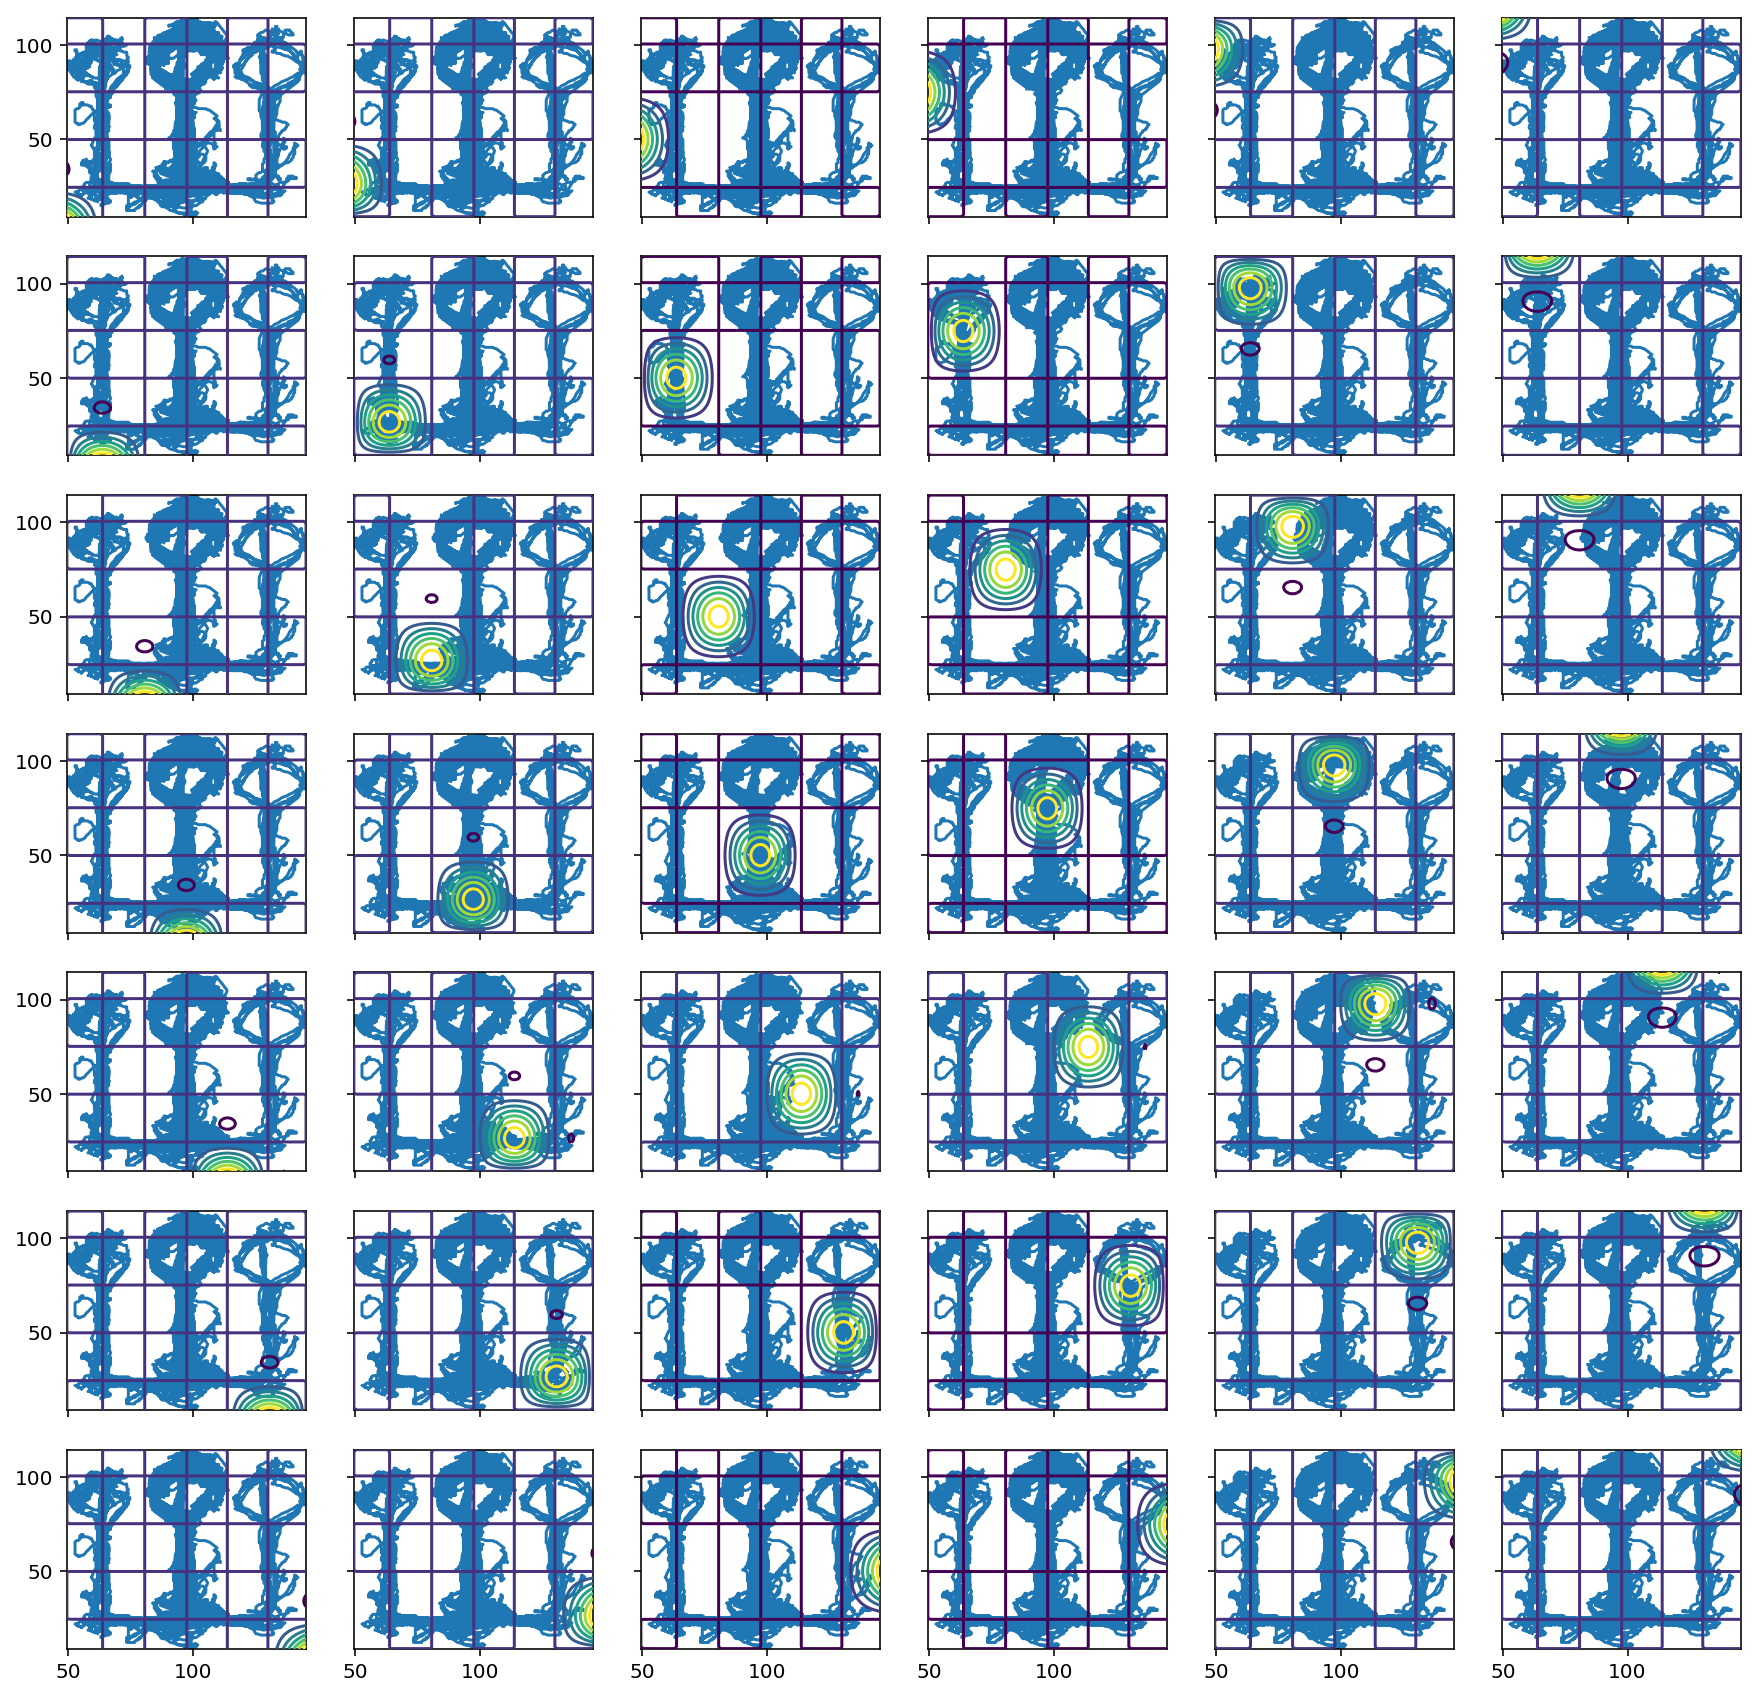

In [422]:
d = dmatrix('te(cr(x_position, knots=x_knots), cr(y_position, knots=y_knots)) - 1', predict_data)
fig, axes = plt.subplots(len(x_knots) + 2, len(y_knots) + 2, figsize=(15, 15), sharex=True, sharey=True)
for ax, z in zip(axes.ravel(), d.T):
    ax.plot(data.x_position, data.y_position)
    ax.contour(x, y, z.reshape(x.shape), zorder=100)

In [446]:
formula = 'is_spike ~ 1 + te(cr(x_position, knots=x_knots), cr(y_position, knots=y_knots), constraints="center")'
penalty = 1E-4

response, design_matrix = dmatrices(formula, data, return_type='dataframe')
model = GLM(response, design_matrix, family=families.Poisson())
regularization_weights = np.ones((design_matrix.shape[1],)) * penalty
regularization_weights[model.exog_names.index('Intercept')] = 0.0
fit = model.fit_regularized(alpha=regularization_weights, L1_wt=0)
model_coefficients = fit.params

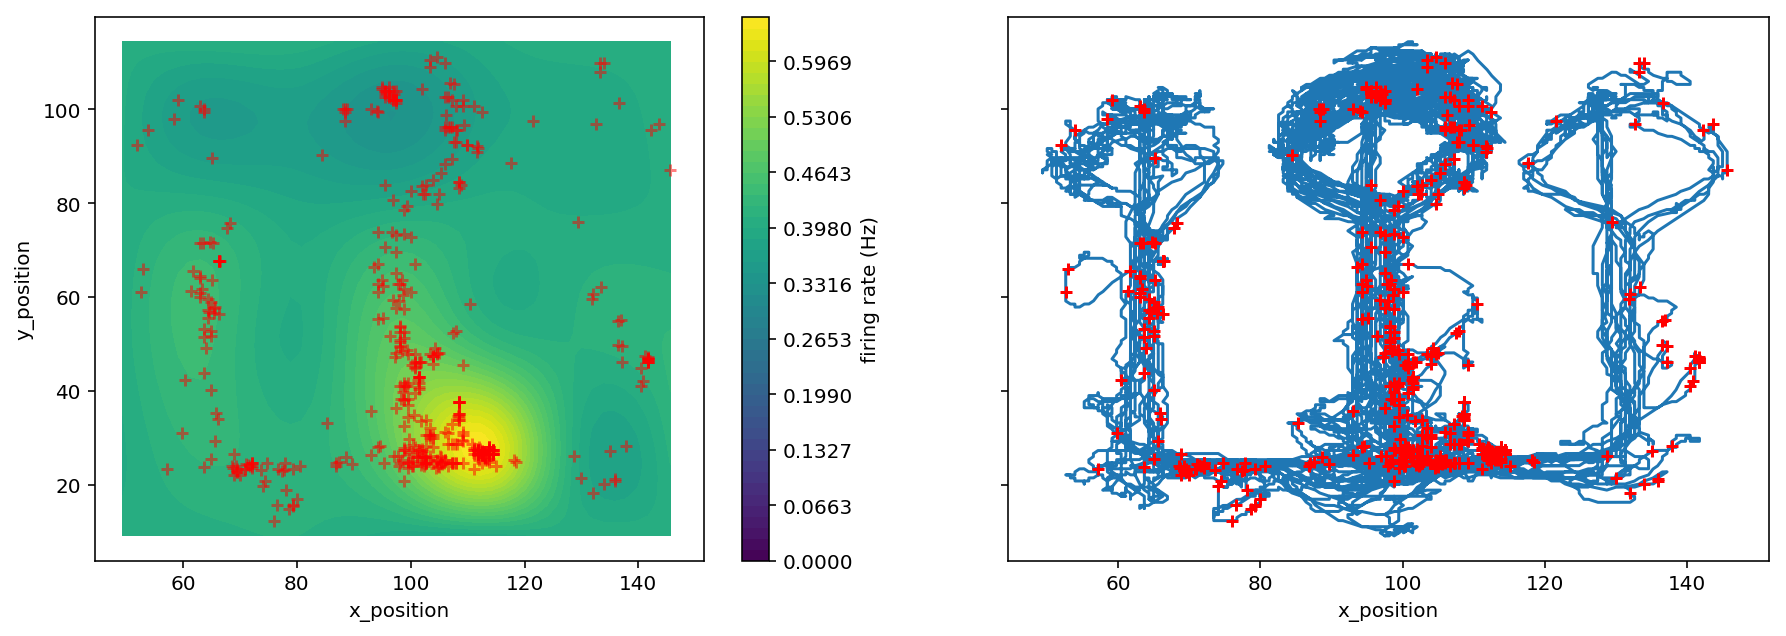

In [458]:
x = np.linspace(data.x_position.min(), data.x_position.max(), 50)
y = np.linspace(data.y_position.min(), data.y_position.max(), 50)
x, y = np.meshgrid(x, y)
predict_data = {'x_position': x.ravel(), 'y_position': y.ravel()}
predict_design_matrix = build_design_matrices(
    [design_matrix.design_info], predict_data)[0]

firing_rate = np.exp(np.dot(predict_design_matrix, model_coefficients)) * SAMPLING_FREQUENCY
max_rate = np.round(np.max(np.exp(np.dot(design_matrix, model_coefficients)) * SAMPLING_FREQUENCY), decimals=2)

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
m = axes[0].contourf(x, y, firing_rate.reshape(x.shape), np.linspace(0, max_rate));
plt.colorbar(m, ax=axes[0], label='firing rate (Hz)')
axes[0].scatter(data.x_position[s], data.y_position[s],
                marker='+', color='red', s=40, zorder=100, alpha=0.5)
axes[0].set_xlabel('x_position')
axes[0].set_ylabel('y_position')
axes[1].plot(data.x_position, data.y_position)
s = data.is_spike > 0
axes[1].scatter(data.x_position[s], data.y_position[s], marker='+', color='red', s=40, zorder=100)
axes[1].set_xlabel('x_position');

### 3D model of Position and Speed

In [428]:
speed_knots = [1, 3, 10, 30]
formula = 'is_spike ~ 1 + te(cr(x_position, knots=x_knots), cr(y_position, knots=y_knots), cr(speed, knots=speed_knots), constraints="center")'
penalty = 1E-4

response, design_matrix = dmatrices(formula, data, return_type='dataframe')
model = GLM(response, design_matrix, family=families.Poisson())
regularization_weights = np.ones((design_matrix.shape[1],)) * penalty
regularization_weights[model.exog_names.index('Intercept')] = 0.0
fit = model.fit_regularized(alpha=regularization_weights, L1_wt=0)
model_coefficients = fit.params

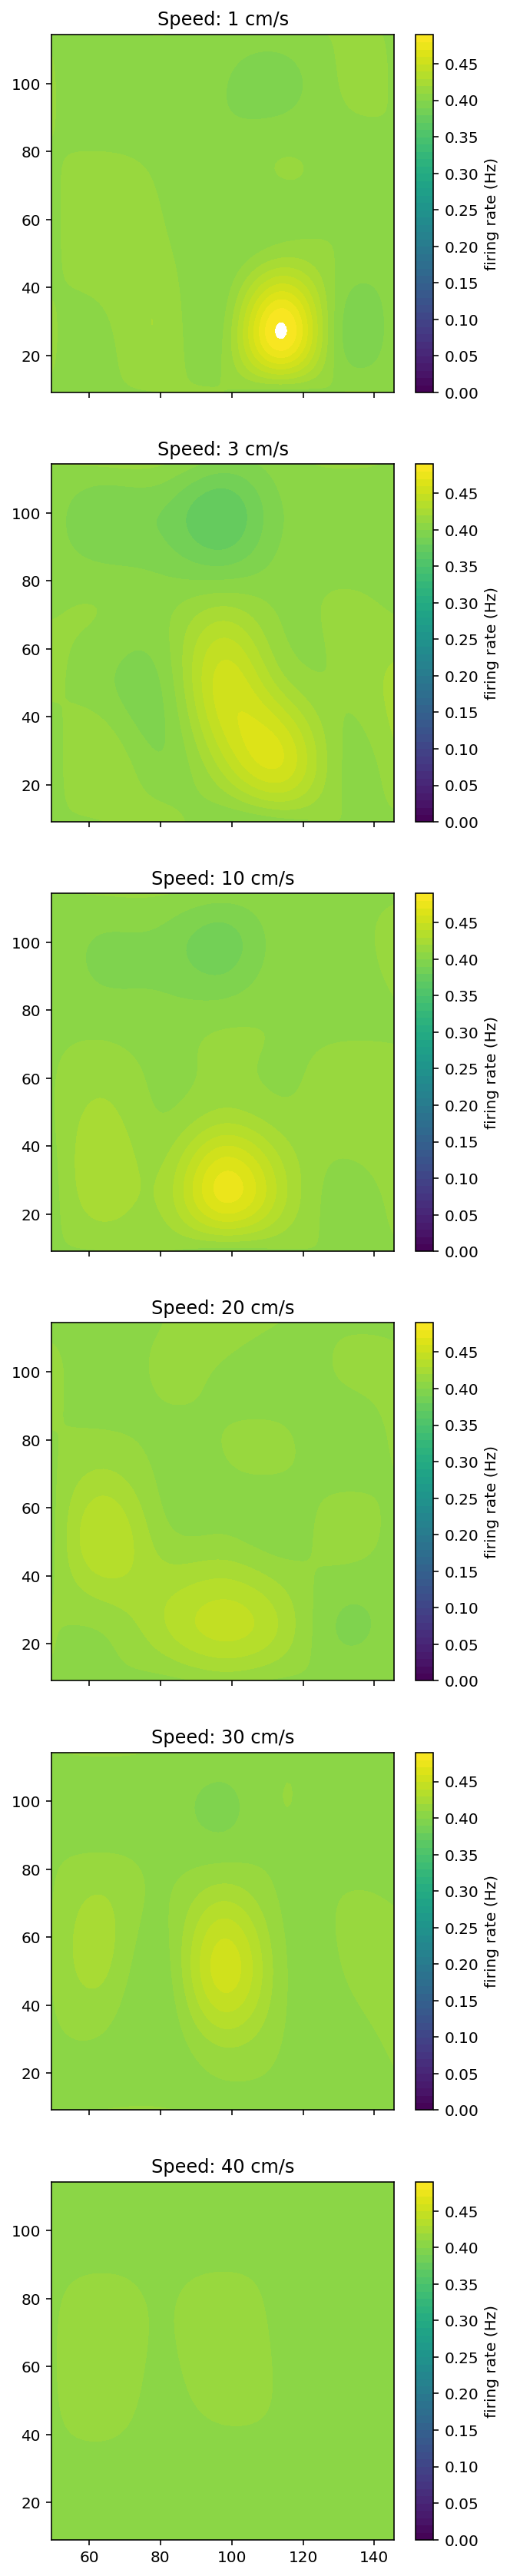

In [444]:
def plot_position_by_speed(data, design_matrix, model_coefficients, speed=20, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(data.x_position.min(), data.x_position.max(), 100)
    y = np.linspace(data.y_position.min(), data.y_position.max(), 100)
    x, y = np.meshgrid(x, y)
    predict_data = {'x_position': x.ravel(), 'y_position': y.ravel(), 'speed': np.ones_like(x.ravel()) * speed}
    predict_design_matrix = build_design_matrices(
        [design_matrix.design_info], predict_data)[0]
    max_rate = np.round(np.max(np.exp(np.dot(design_matrix, model_coefficients)) * SAMPLING_FREQUENCY), decimals=2)

    firing_rate = np.exp(np.dot(predict_design_matrix, model_coefficients)) * SAMPLING_FREQUENCY
    mappable = ax.contourf(x, y, firing_rate.reshape(x.shape), np.arange(0, max_rate, .01));
    plt.colorbar(mappable, ax=ax, label='firing rate (Hz)')
    ax.set_title('Speed: {0} cm/s'.format(speed))

speeds = [1, 3, 10, 20, 30, 40]
n_speeds = len(speeds)
fig, axes = plt.subplots(n_speeds, 1, sharex=True, sharey=True, figsize=(5, 5 * n_speeds))
for ax, speed in zip(axes, speeds):
    plot_position_by_speed(data, design_matrix, model_coefficients, speed=speed, ax=ax)

### Functions

In [467]:
def cluster(data, maxgap=5):
    '''Arrange data into groups where successive elements
       differ by no more than *maxgap*

        >>> cluster([1, 6, 9, 100, 102, 105, 109, 134, 139], maxgap=10)
        [[1, 6, 9], [100, 102, 105, 109], [134, 139]]

        >>> cluster([1, 6, 9, 99, 100, 102, 105, 134, 139, 141], maxgap=10)
        [[1, 6, 9], [99, 100, 102, 105], [134, 139, 141]]
        https://stackoverflow.com/questions/14783947/grouping-clustering-numbers-in-python
    '''
    data.sort()
    groups = [[data[0]]]
    for x in data[1:]:
        if abs(x - groups[-1][-1]) <= maxgap:
            groups[-1].append(x)
        else:
            groups.append([x])
    return groups


def insert_points(data, min_diff=30):    
    new_points = []
    for i, d in enumerate(np.diff(data)):
        if d > min_diff:
            n = np.ceil(d / min_diff).astype(int)
            new_diff = d / n
            new_points.append(data[i] + np.arange(1, n) * new_diff)
    return np.sort(np.concatenate((data, *new_points)))


def get_position_knots(epoch_key, animals):
    animal, day, epoch = epoch_key
    task_file = get_data_structure(animals[animal], day, 'task', 'task')
    linearcoord = task_file[epoch - 1]['linearcoord'][0, 0].squeeze()

    coordinates = np.concatenate([arm[:, :, 0] for arm in linearcoord])
    coordinates = np.unique(coordinates, axis=0)
    
    knots = [insert_points(np.mean(cluster(dim), axis=1), min_diff=30)
             for dim in coordinates.T]
    return tuple(knots)

x_knots, y_knots = get_position_knots(epoch_key, ANIMALS)

In [470]:
def fit_2D_position(neuron_key, animals):
    spikes = get_spike_indicator_dataframe(neuron_key, animals).rename('is_spike')
    position_info = get_interpolated_position_dataframe(neuron_key[:-2], animals)
    data = (position_info.join(spikes)
            .drop(['from_well', 'to_well', 'labeled_segments', 'is_correct', 'task'], axis=1)
            .dropna())
    x_knots, y_knots = get_position_knots(neuron_key[:-2], animals)
    formula = 'is_spike ~ 1 + te(cr(x_position, knots=x_knots), cr(y_position, knots=y_knots), constraints="center")'
    penalty = 1E-4

    response, design_matrix = dmatrices(formula, data, return_type='dataframe')
    model = GLM(response, design_matrix, family=families.Poisson())
    regularization_weights = np.ones((design_matrix.shape[1],)) * penalty
    regularization_weights[model.exog_names.index('Intercept')] = 0.0
    fit = model.fit_regularized(alpha=regularization_weights, L1_wt=0)

    return design_matrix, fit.params, data

neuron_key = ('HPa', 6, 2, 1, 5)
design_matrix, model_coefficients, data = fit_2D_position(neuron_key, ANIMALS)

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/EEG/HPaeeg06-2-20.mat
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/loren_frank_data_processing/position.py:193: RuntimeWarning: invalid value encountered in less
  at_target = distance_from_target < max_distance


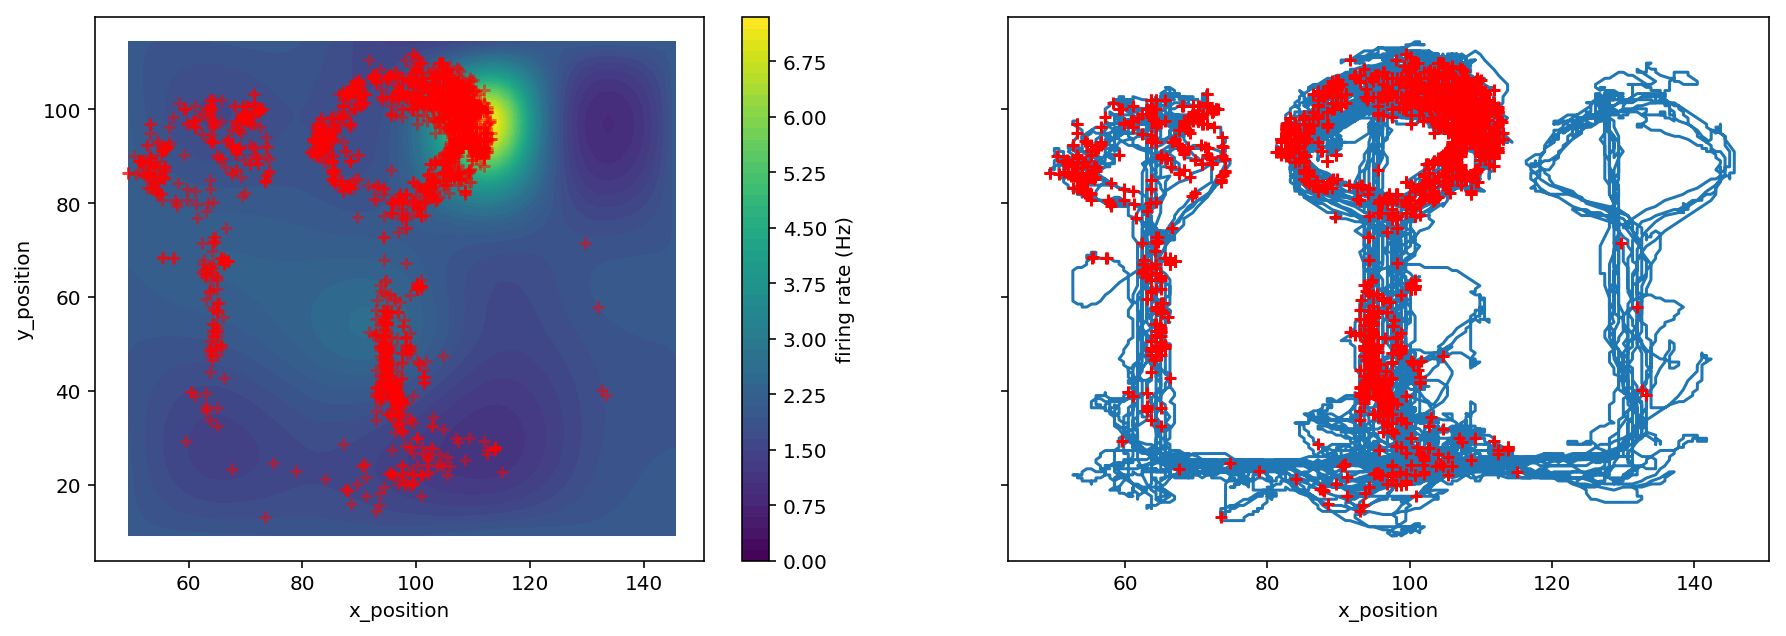

In [474]:
def plot_2D_position(design_matrix, model_coefficients, data, plot_raster=True):
    x = np.linspace(data.x_position.min(), data.x_position.max(), 50)
    y = np.linspace(data.y_position.min(), data.y_position.max(), 50)
    x, y = np.meshgrid(x, y)
    predict_data = {'x_position': x.ravel(), 'y_position': y.ravel()}
    predict_design_matrix = build_design_matrices(
        [design_matrix.design_info], predict_data)[0]

    firing_rate = np.exp(np.dot(predict_design_matrix, model_coefficients)) * SAMPLING_FREQUENCY
    max_rate = np.ceil(np.max(np.exp(np.dot(design_matrix, model_coefficients)) * SAMPLING_FREQUENCY))

    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    m = axes[0].contourf(x, y, firing_rate.reshape(x.shape), np.arange(0, max_rate + 1))
    s = data.is_spike > 0
    plt.colorbar(m, ax=axes[0], label='firing rate (Hz)')
    if plot_raster:
        axes[0].scatter(data.x_position[s], data.y_position[s],
                        marker='+', color='red', s=40, zorder=100, alpha=0.5)
    axes[0].set_xlabel('x_position')
    axes[0].set_ylabel('y_position')
    axes[1].plot(data.x_position, data.y_position)
    axes[1].scatter(data.x_position[s], data.y_position[s], marker='+', color='red', s=40, zorder=100)
    axes[1].set_xlabel('x_position');
    
plot_2D_position(design_matrix, model_coefficients, data)

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/EEG/HPaeeg06-2-20.mat
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/loren_frank_data_processing/position.py:193: RuntimeWarning: invalid value encountered in less
  at_target = distance_from_target < max_distance


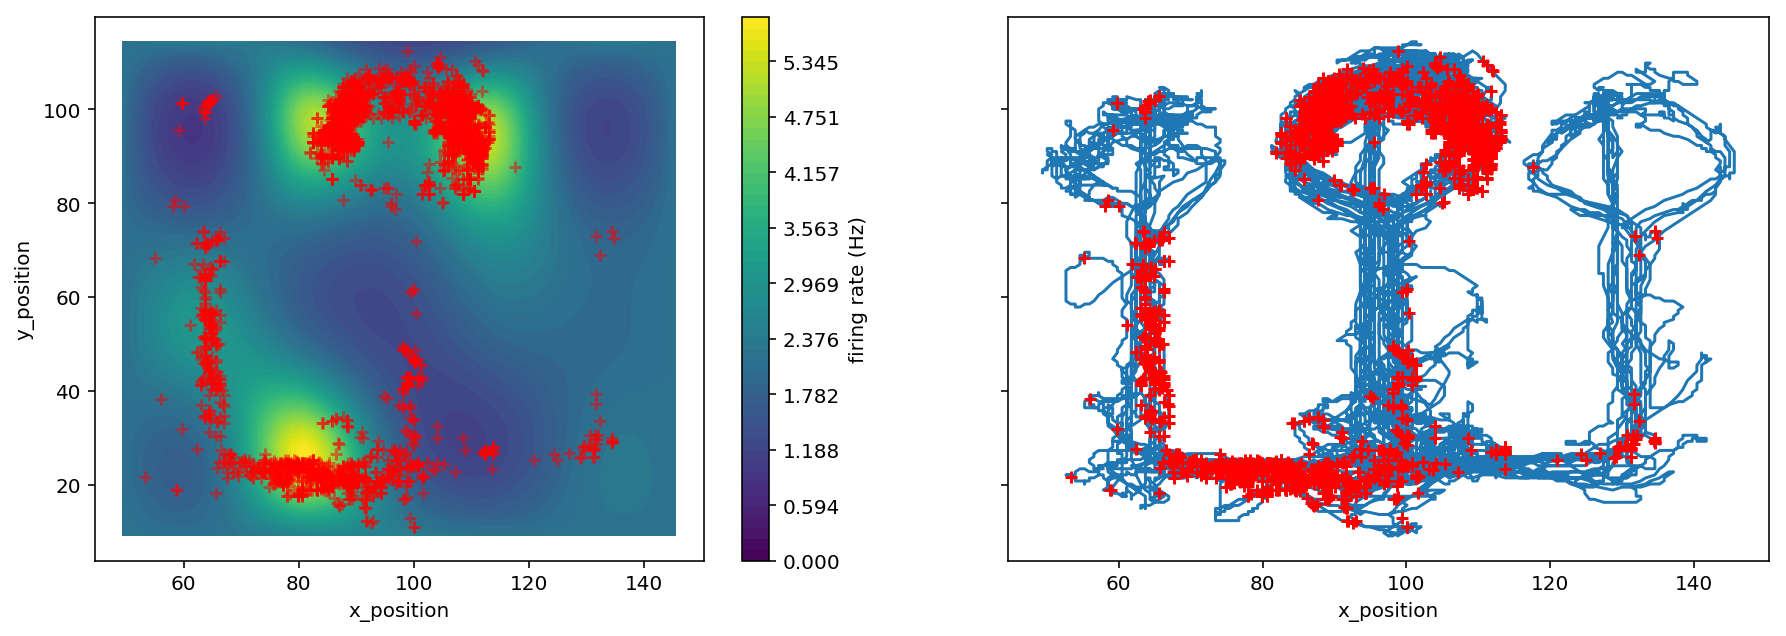

In [475]:
neuron_key = ('HPa', 6, 2, 5, 2)
design_matrix, model_coefficients, data = fit_2D_position(neuron_key, ANIMALS)
plot_2D_position(design_matrix, model_coefficients, data)

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/EEG/HPaeeg06-2-20.mat
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/loren_frank_data_processing/position.py:193: RuntimeWarning: invalid value encountered in less
  at_target = distance_from_target < max_distance


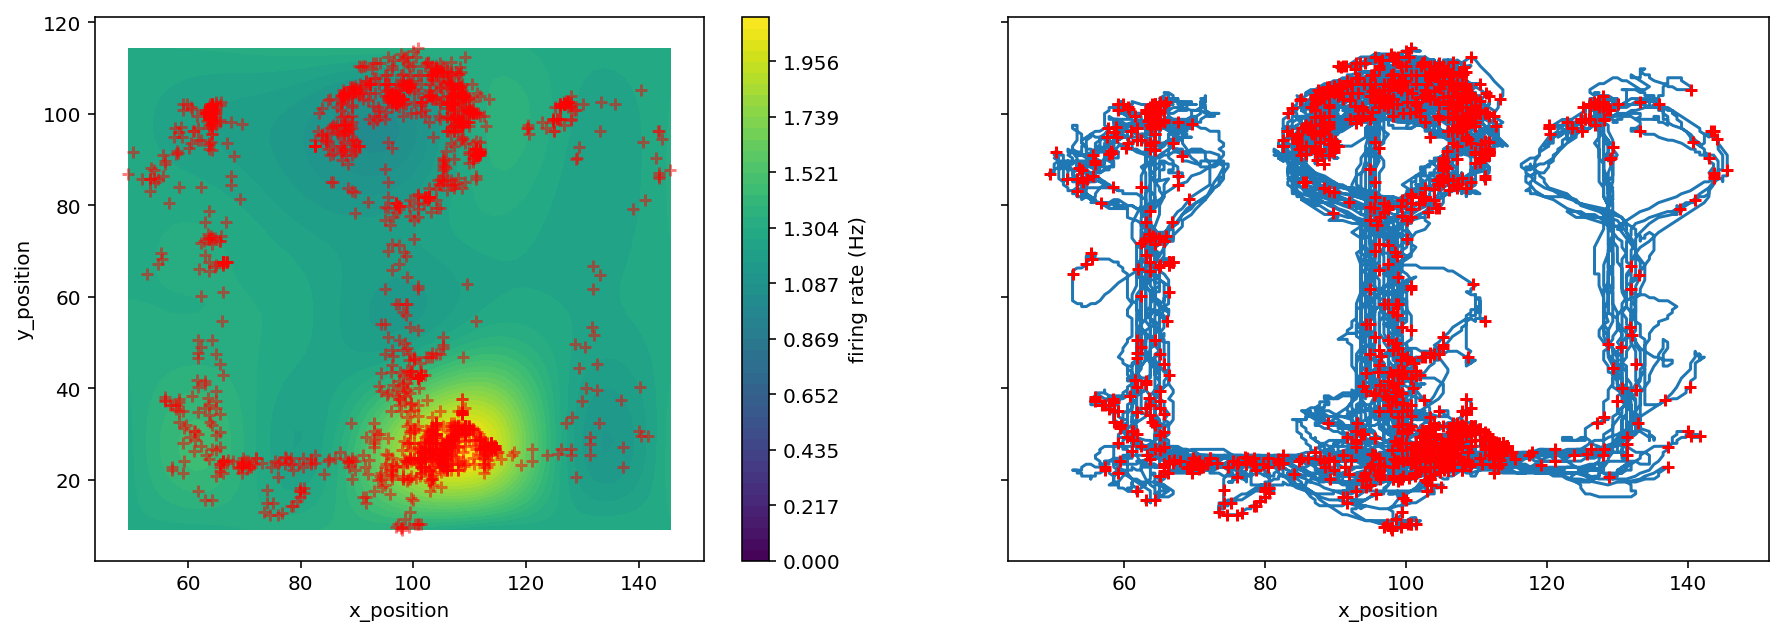

In [477]:
neuron_key = ('HPa', 6, 2, 18, 1)
design_matrix, model_coefficients, data = fit_2D_position(neuron_key, ANIMALS)
plot_2D_position(design_matrix, model_coefficients, data)


ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/EEG/HPaeeg06-2-20.mat
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/loren_frank_data_processing/position.py:193: RuntimeWarning: invalid value encountered in less
  at_target = distance_from_target < max_distance


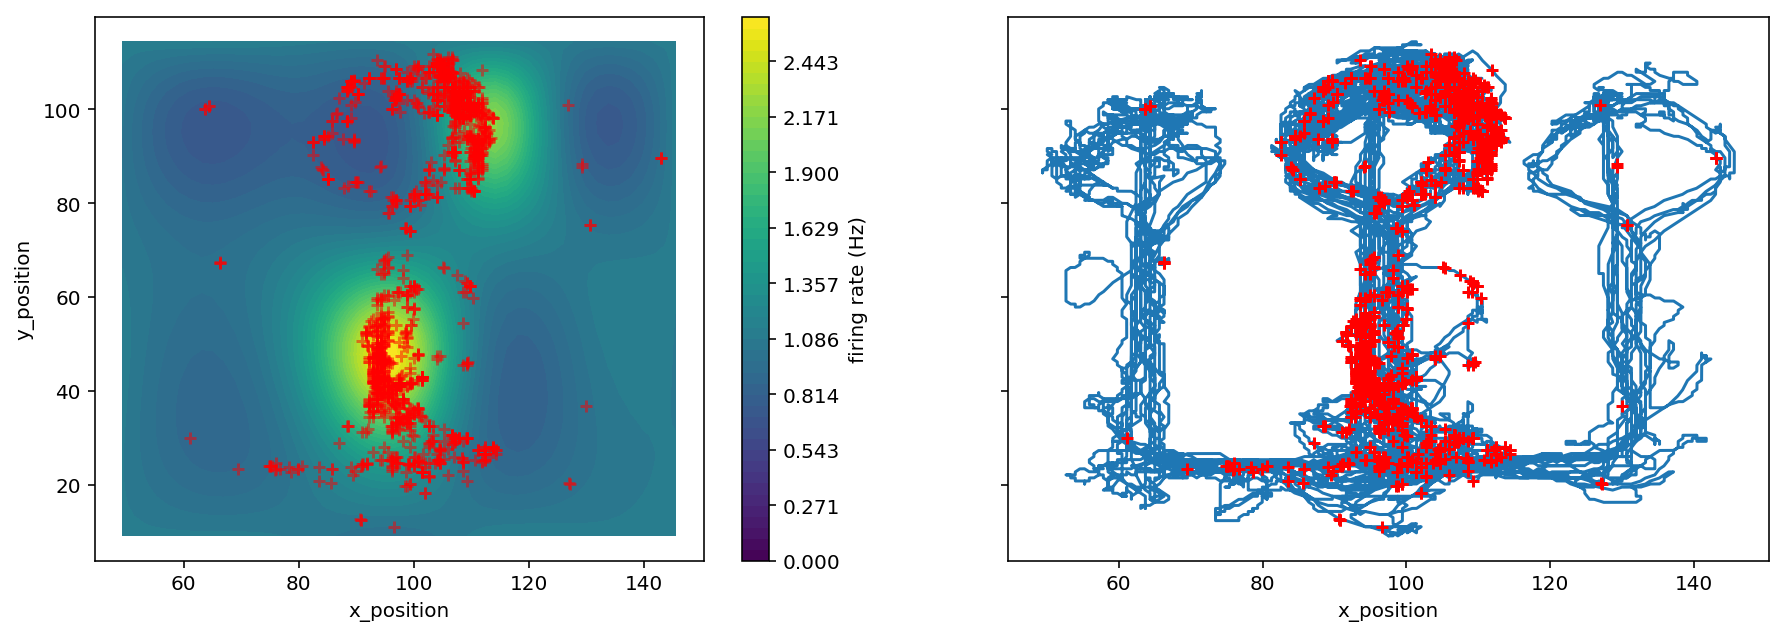

In [478]:
neuron_key = ('HPa', 6, 2, 11, 1)
design_matrix, model_coefficients, data = fit_2D_position(neuron_key, ANIMALS)
plot_2D_position(design_matrix, model_coefficients, data)


ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/EEG/HPaeeg06-2-20.mat
/Users/edeno/miniconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.6/site-packages/loren_frank_data_processing/position.py:193: RuntimeWarning: invalid value encountered in less
  at_target = distance_from_target < max_distance


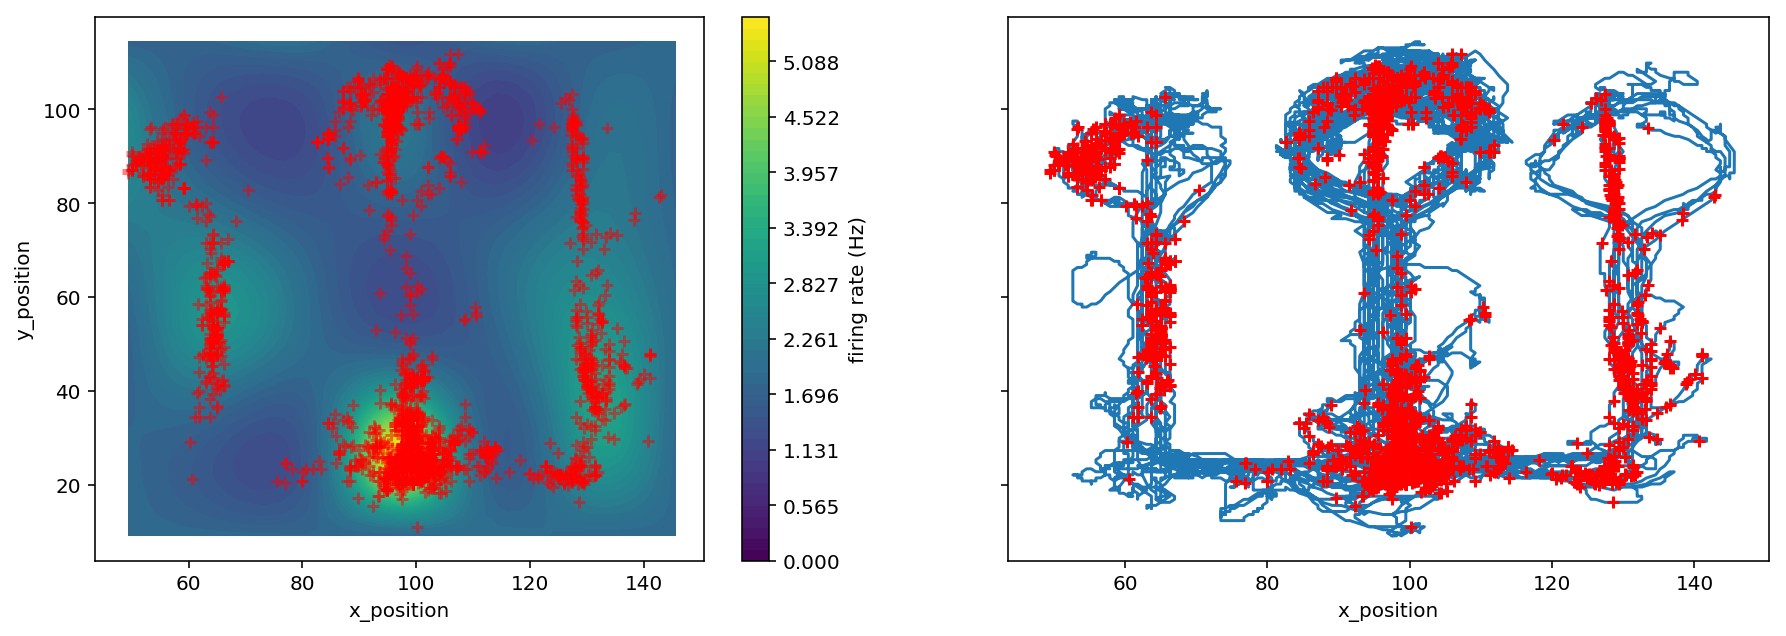

In [479]:
neuron_key = ('HPa', 6, 2, 5, 5)
design_matrix, model_coefficients, data = fit_2D_position(neuron_key, ANIMALS)
plot_2D_position(design_matrix, model_coefficients, data)


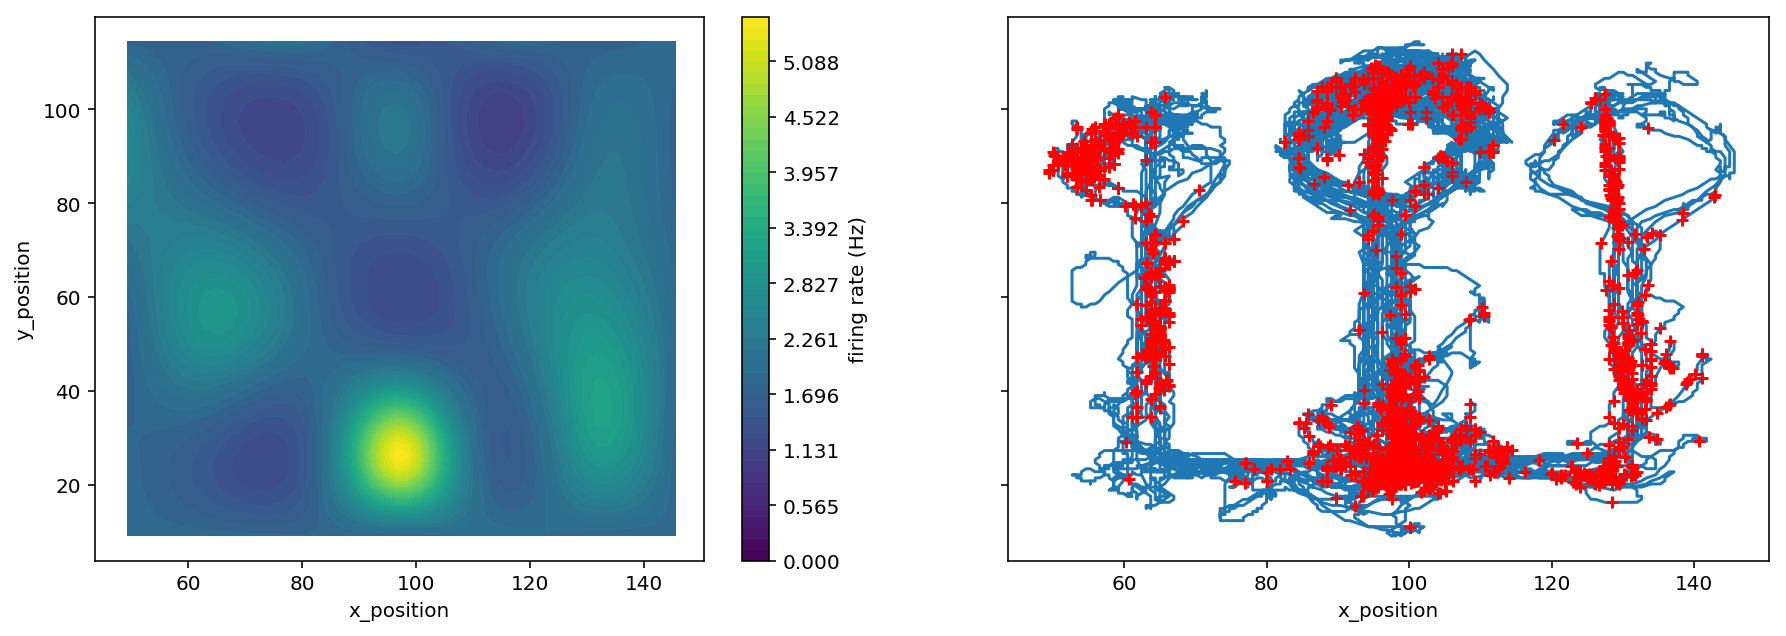

In [482]:
plot_2D_position(design_matrix, model_coefficients, data, plot_raster=False)